In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_Village",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 1 2 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[111.  98. 105.]
  [101.  88.  95.]
  [145. 132. 139.]
  ...
  [166. 156. 164.]
  [164. 154. 162.]
  [165. 155. 163.]]

 [[120. 107. 114.]
  [111.  98. 105.]
  [145. 132. 139.]
  ...
  [164. 154. 162.]
  [164. 154. 162.]
  [166. 156. 164.]]

 [[122. 109. 116.]
  [118. 105. 112.]
  [139. 126. 133.]
  ...
  [165. 155. 163.]
  [166. 156. 164.]
  [170. 160. 168.]]

 ...

 [[ 99.  87.  97.]
  [109.  97. 107.]
  [107.  95. 105.]
  ...
  [146. 138. 149.]
  [147. 139. 150.]
  [145. 137. 148.]]

 [[104.  92. 102.]
  [110.  98. 108.]
  [110.  98. 108.]
  ...
  [141. 133. 144.]
  [142. 134. 145.]
  [141. 133. 144.]]

 [[104.  92. 102.]
  [107.  95. 105.]
  [108.  96. 106.]
  ...
  [135. 127. 138.]
  [137. 129. 140.]
  [136. 128. 139.]]]


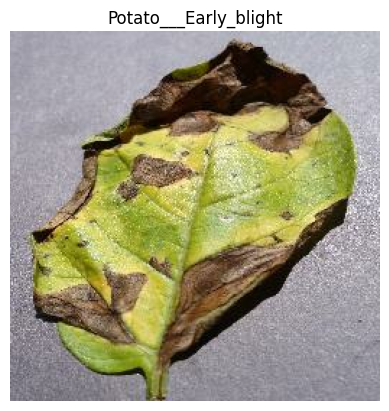

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

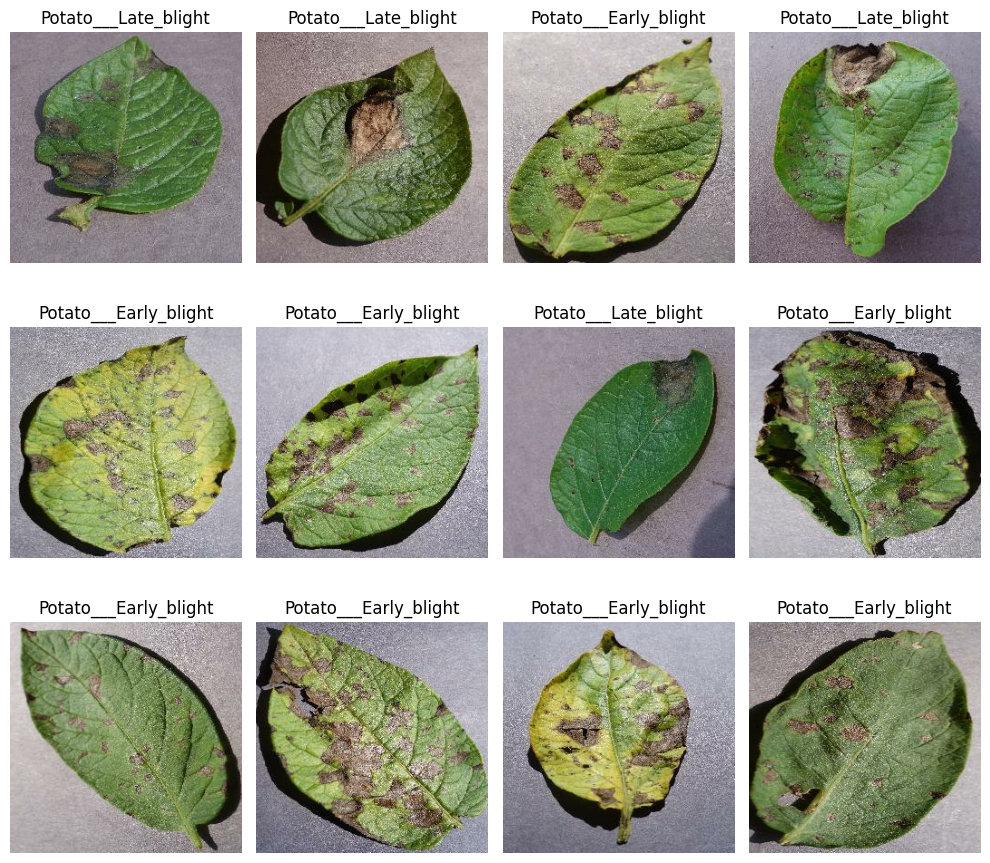

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        plt.tight_layout()

In [10]:
len(dataset)

68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
# splitting data for training, testing, validation

train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

We can make a funtion for this 

In [17]:
def get_data_partition(ds, train_split = 0.8, test_split = 0.1, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)


    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_data_partition(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
# Scaling the images

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [24]:
# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

MODEL BUILDING

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])


model.build(input_shape = input_shape)

c:\Users\Dinesh\anaconda3\envs\mlenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4738 - loss: 0.9375 - val_accuracy: 0.5885 - val_loss: 0.7761
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6754 - loss: 0.7255 - val_accuracy: 0.6562 - val_loss: 0.7610
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7706 - loss: 0.5733 - val_accuracy: 0.8542 - val_loss: 0.3143
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8651 - loss: 0.3437 - val_accuracy: 0.8125 - val_loss: 0.4655
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8837 - loss: 0.3284 - val_accuracy: 0.9115 - val_loss: 0.1866
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9413 - loss: 0.1592 - val_accuracy: 0.9010 - val_loss: 0.2762
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9527 - loss: 0.1265 - val_accuracy: 0.9531 - val_loss: 0.1325
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9382 - loss: 0.1666 - val_accuracy: 0.8385 - val_loss:

In [30]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - accuracy: 0.9701 - loss: 0.0783


In [31]:
scores

[0.07081055641174316, 0.97265625]

In [32]:
history  # 

In [33]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
history.history['accuracy']

[0.5248842835426331,
 0.6799768805503845,
 0.8003472089767456,
 0.8587962985038757,
 0.8883101940155029,
 0.9444444179534912,
 0.9473379850387573,
 0.9403935074806213,
 0.9537037014961243,
 0.9635416865348816]

Plot the training history on graph

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

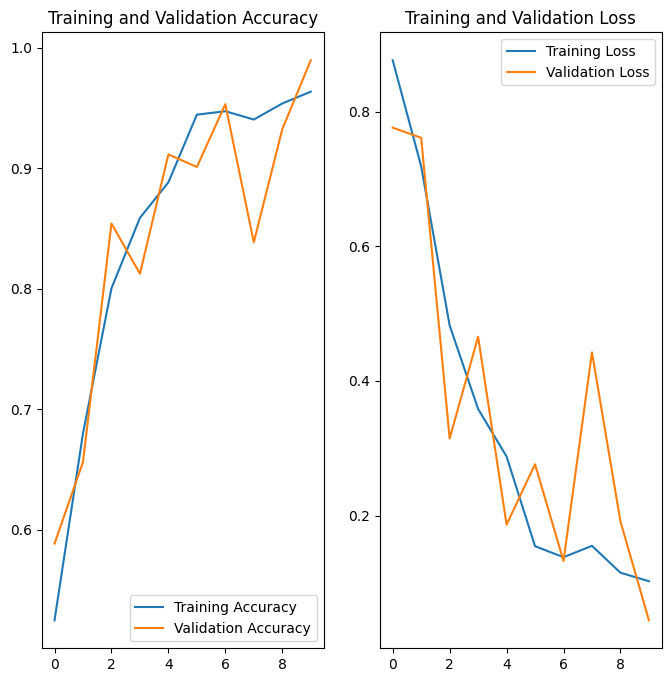

In [37]:
EPOCHS = 10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")




first image to predict
first image actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
prediced image label:  Potato___Early_blight


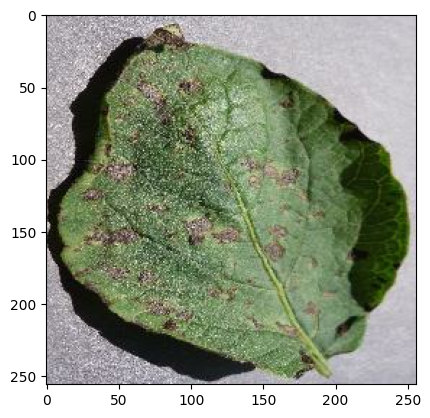

In [38]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("prediced image label: ",class_names[np.argmax(batch_prediction[0])])

we can make a function for prediction

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


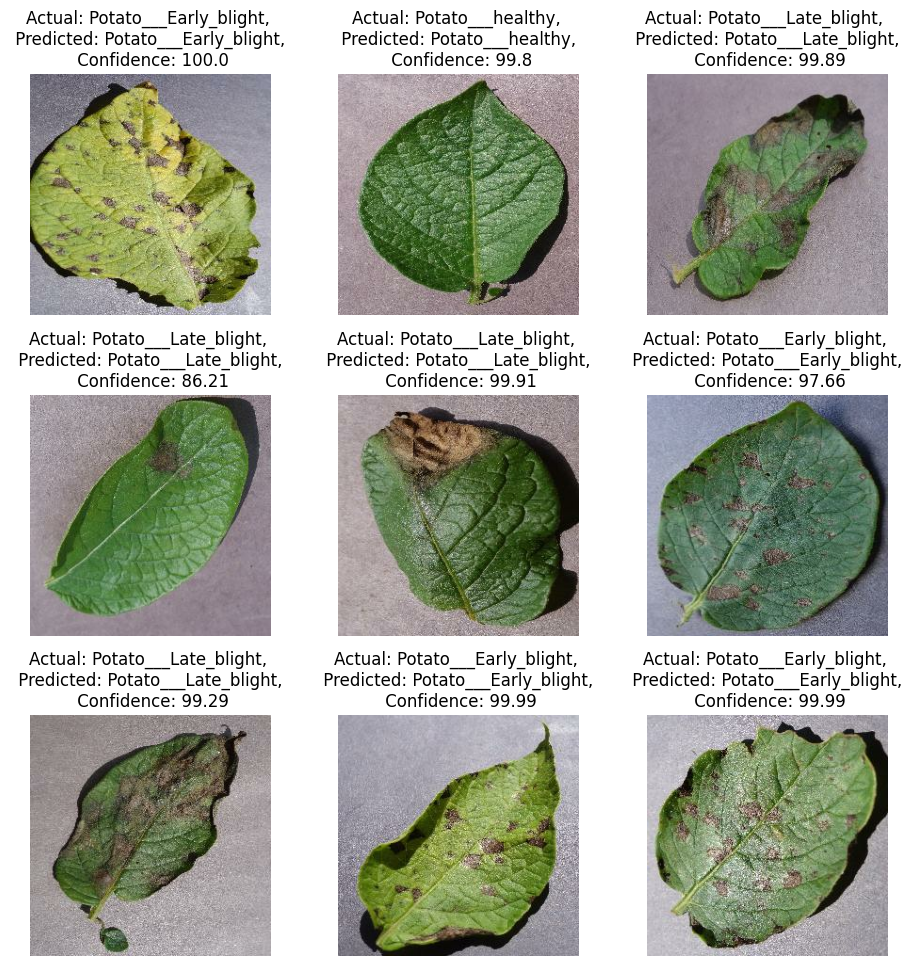

In [40]:
plt.figure(figsize = (10,10))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}")

        plt.tight_layout()
        plt.axis("off")

In [51]:
model_version = 1
model.export(f"Models/ {model_version}")

INFO:tensorflow:Assets written to: Models/ 1\assets


INFO:tensorflow:Assets written to: Models/ 1\assets


Saved artifact at 'Models/ 1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1557518453216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518453392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518455152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518455856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454800: TensorSpec(shape=(), dty

In [53]:
# For creating multiple model version with changes paramters

import os
model_version = max([int(i) for i in os.listdir("Models")]) +1
model.export(f"Models/ {model_version}")

INFO:tensorflow:Assets written to: Models/ 2\assets


INFO:tensorflow:Assets written to: Models/ 2\assets


Saved artifact at 'Models/ 2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1557518453216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518453392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518455152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518455856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518456736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1557518454800: TensorSpec(shape=(), dty